# SG-MCMC Sampling - Hands-on
This notebook implements sgmcmc samplers to test them on simple landscapes. So we are able to get a feeling for their differences and behavior.

In [9]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from enhancing_sgmcmc.samplers.sghmc import SGHMC
from enhancing_sgmcmc.utils import gaussian_mixture_logprob

### Setup

In [2]:
means = jnp.array([[-5.0, -5.0], [5.0, 5.0], [5.0, -5.0], [-5.0, 5.0]])
covs = jnp.array(
    [
        [[1.0, 0.0], [0.0, 1.0]],
        [[1.0, 0.0], [0.0, 1.0]],
        [[1.0, 0.0], [0.0, 1.0]],
        [[1.0, 0.0], [0.0, 1.0]],
    ]
)
weights = jnp.array([0.25, 0.25, 0.25, 0.25])

In [3]:
def grad_estimator(position, x=None, y=None):
    """Gradient estimator for Gaussian mixture model."""
    # In this example, x and y are not used as we're directly sampling from a distribution
    logprob = gaussian_mixture_logprob(position, means, covs, weights)
    return logprob, jax.grad(gaussian_mixture_logprob)(position, means, covs, weights)

In [6]:
# Initialize sampler
sampler = SGHMC(grad_estimator)
init_position = jnp.array([0.0, 0.0])  # Start at the origin
state = sampler.init_state(init_position)

# Sample trajectory
num_samples = 3000
trajectory = np.zeros((num_samples, 2))
trajectory[0] = np.array(state.position)

In [7]:
key = jax.random.PRNGKey(0)
for i in range(1, num_samples):
    key, subkey = jax.random.split(key)
    # Create a dummy minibatch (not used in this example)
    dummy_minibatch = (jnp.array([0.0]), jnp.array([0.0]))
    state = sampler.sample_step(
        state=state,
        rng_key=subkey,
        minibatch=dummy_minibatch,
        step_size=0.05,
        mdecay=0.05,
        num_integration_steps=1,
    )
    trajectory[i] = np.array(state.position)

# Create a grid for contour plot
x = np.linspace(-10, 10, 200)
y = np.linspace(-10, 10, 200)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

# Compute density values on the grid
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        point = jnp.array([X[i, j], Y[i, j]])
        Z[i, j] = np.exp(gaussian_mixture_logprob(point, means, covs, weights))

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


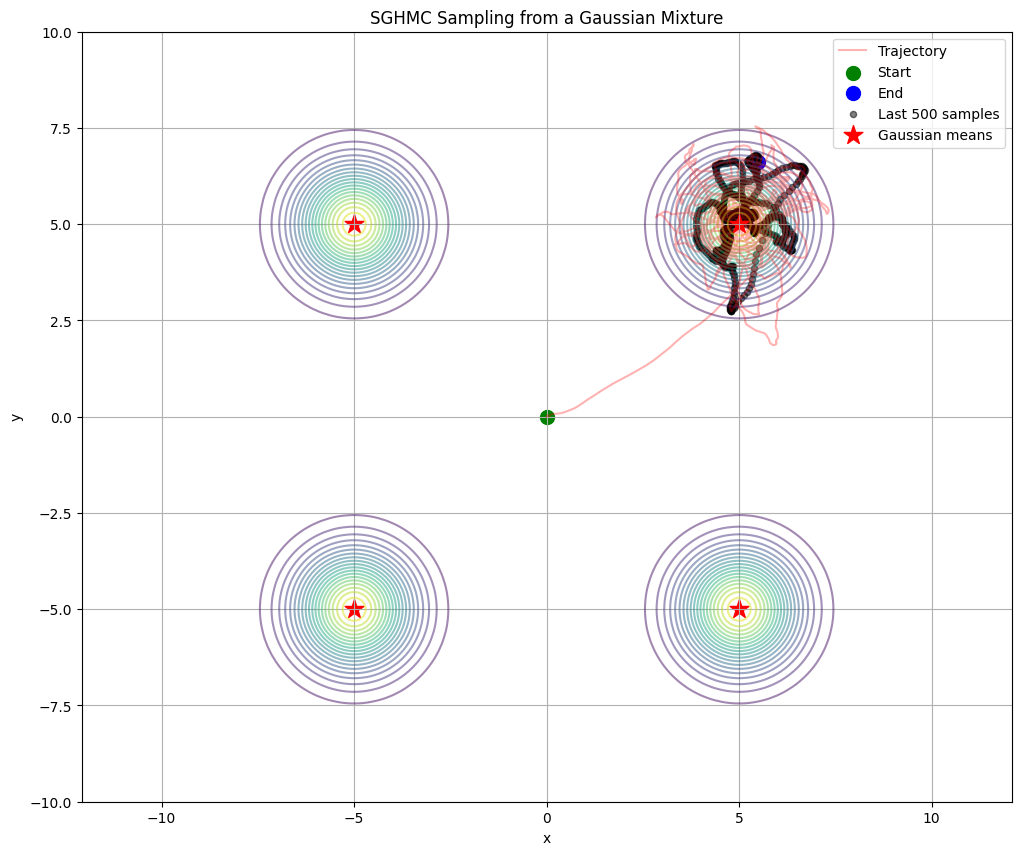

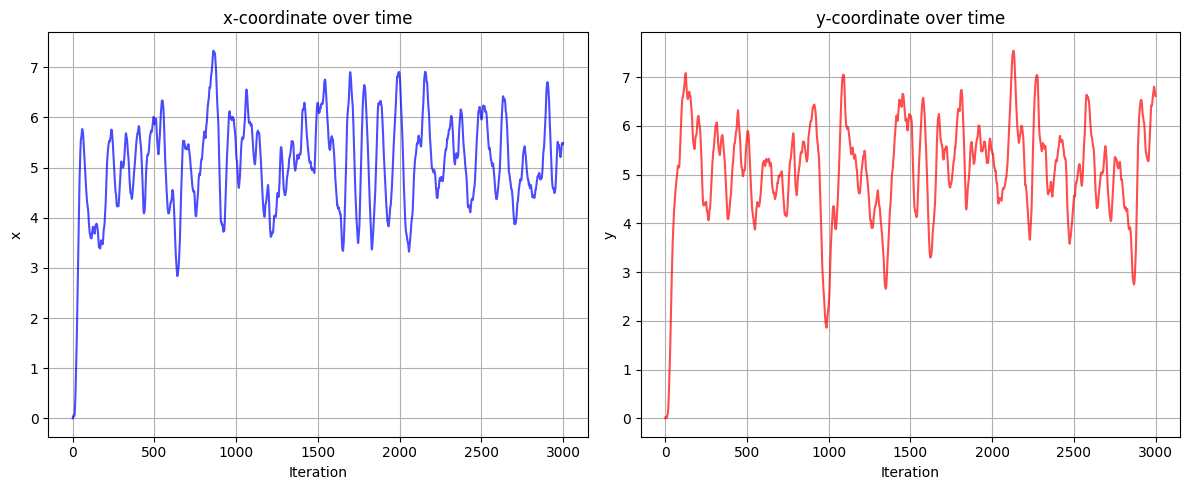

In [ ]:
plt.figure(figsize=(12, 10))

# Plot contours of the density
plt.contour(X, Y, Z, levels=20, cmap="viridis", alpha=0.5)

# Plot the sampling trajectory
plt.plot(trajectory[:, 0], trajectory[:, 1], "r-", alpha=0.3, label="Trajectory")
plt.scatter(trajectory[0, 0], trajectory[0, 1], c="green", s=100, label="Start")
plt.scatter(trajectory[-1, 0], trajectory[-1, 1], c="blue", s=100, label="End")

# Add points from the last 500 samples
plt.scatter(
    trajectory[-500:, 0], trajectory[-500:, 1], c="black", s=20, alpha=0.5, label="Last 500 samples"
)

# Plot the means of the Gaussian components
plt.scatter(means[:, 0], means[:, 1], c="red", s=200, marker="*", label="Gaussian means")

plt.title("SGHMC Sampling from a Gaussian Mixture")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

# Plot trajectory over time to show mixing
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(trajectory[:, 0], "b-", alpha=0.7)
plt.title("x-coordinate over time")
plt.xlabel("Iteration")
plt.ylabel("x")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(trajectory[:, 1], "r-", alpha=0.7)
plt.title("y-coordinate over time")
plt.xlabel("Iteration")
plt.ylabel("y")
plt.grid(True)

plt.tight_layout()
plt.show()